# TD3 - Maxime Corda

In [1]:
import plotly
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as clr
import matplotlib.animation as animation
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.lines import Line2D
from scipy.signal import fftconvolve
from sklearn.svm import LinearSVC
from itertools import *
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn import linear_model

!git clone https://github.com/HNinou/MathTools_TD2
!unzip MathTools_TD2/dic_cont8_GO.npy.zip -d MathTools_TD2/

Cloning into 'MathTools_TD2'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 1), reused 10 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 16.96 MiB | 15.25 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Archive:  MathTools_TD2/dic_cont8_GO.npy.zip
  inflating: MathTools_TD2/dic_cont8_GO.npy  
  inflating: MathTools_TD2/__MACOSX/._dic_cont8_GO.npy  


# Performing PCA on neural data


In [2]:
def gaussian(x, sigma, mu=0):
    return np.exp(-((x-mu)**2) / (2*sigma**2))

def make_conv_kernel( sigma= 30):
    nb_time_frames = 6*sigma
    conv_kernel = gaussian(np.arange(-nb_time_frames//2,nb_time_frames//2,1), sigma=sigma)
    conv_kernel /= np.sum(conv_kernel)

    return conv_kernel

def smoothen_data(dic, sigma=30):
    # Get number of neurons
    nb_neurons = len(dic['mat'])

    # Create the convolution kernel
    conv_kernel = make_conv_kernel(sigma=sigma)

    # Pre-allocate the smooth_mat with the same structure as dic['mat']
    smooth_mat = [None] * nb_neurons

    # Loop over neurons, but vectorize across trials
    for neuron in range(nb_neurons):
        # Get all trials for this neuron as a 2D matrix (nb_trials, time_points)
        mat_neuron = dic['mat'][neuron]

        # Use fftconvolve for faster convolution across all trials
        smooth_neuron = fftconvolve(mat_neuron, conv_kernel[None, :], mode='same', axes=1)

        # Store the result back
        smooth_mat[neuron] = smooth_neuron

    # Replace the original matrix with the smoothed data
    dic['sm_mat'] = smooth_mat
    return dic


def raster_plot(neural_data):
  # Create the raster plot using Plotly
  fig = go.Figure(data=go.Heatmap(
      z=neural_data,
      colorscale='Greys',
      colorbar=dict(
          title="Neural Activity",
          titleside='right',
          ticks='outside',
          ticklen=5,
          tickcolor='black',
      )
  ))

  fig.update_layout(
      title="Neural Activity Raster Plot",
      xaxis=dict(
          title="Time (ms)",
          ticks='outside',
          showline=True,
          linewidth=2,
          linecolor='black',
          mirror=True
      ),
      yaxis=dict(
          title="Trial Index",
          ticks='outside',
          showline=True,
          linewidth=2,
          linecolor='black',
          mirror=True
      ),
      plot_bgcolor='white',
      font=dict(size=14),
  )

  # Display the plot
  fig.show()
  return()

The cell below stores the data in the dictionnary dic_cont8. The raw data is stored in dic_cont8['mat'] which is a list of size 777, that is the total number of neurons. Each element of this list contains a matrix of size (#trials x #timesteps). For each recording, that is for each trial, the data is shifted so that the 'GO' signal always shows up at the 2000th time frame.

In [3]:
# Load the data from the .npy files

centering = 'GO'
dic_cont8 =np.load('MathTools_TD2/dic_cont8_GO.npy', allow_pickle = True).flat[0]
# Smooth the data using a Gaussian filter with a sigma of 100
dic_cont8 = smoothen_data(dic_cont8, sigma=100)

nb_neurons = len(dic_cont8['target'])

nb_trials_cont8 = np.zeros(nb_neurons)
for i in range(nb_neurons):
    nb_trials_cont8[i] = dic_cont8['target'][i].shape[0]

In [4]:
nb_neurons= len(dic_cont8['mat'])
nb_trials = []
for n in range(nb_neurons):
    nb_trials.append(dic_cont8['mat'][n].shape[0])
nb_trials = np.array(nb_trials)


Let's store the number of trials per neuron for each of the 8 targets

In [5]:
nb_neurons= len(dic_cont8['mat'])
nb_trials_per_c = np.zeros((8,nb_neurons))
for k,target in enumerate(range(1,9)):
  for n in range(nb_neurons):
    nb_trials_per_c[k, n] = dic_cont8['mat'][n][dic_cont8['target'][n]==target].shape[0]


# 1) Fill in the cell below

In [6]:
neuron_filter_ct = np.zeros(nb_neurons) == 0

for n in range(nb_neurons):
  for target in range(1,9):
    if (dic_cont8['target'][n] == target).sum() < 20 :
        neuron_filter_ct[n] = False

In [7]:
neuron_filter_ct.sum()

245

There are 245 neurons fulfilling this condition.

In [8]:
# put the 10 first trials in the training set and the 2 last in the testing set

X = []
for n in range(nb_neurons):
    if neuron_filter_ct[n]:
        res = []
        for target in range(1,9):
            filter_res = np.where(dic_cont8['target'][n] == target)[0][:20]
            res.append(dic_cont8['sm_mat'][n][filter_res][:,1700:1701].mean(axis = 0).flatten())

        res = np.array(res)

        X.append(res.flatten())


X = np.array(X)

X -= X.mean(axis = 1)[:,None]

In [9]:
C = X@X.T/neuron_filter_ct.sum()
eigval, eigvec = np.linalg.eigh(C)

In [10]:
colors = np.zeros(400*8)
for target in range(8):
    colors[target:(target+1)] = target/7

fig = go.Figure()

# Add a 3D scatter plot with PC1, PC2, and PC3 as axes
fig.add_trace(go.Scatter3d(
    x=(eigvec[:,-1]  @ X),
    y=(eigvec[:,-2]  @ X),
    z=(eigvec[:,-3]  @ X),
    mode='markers',
    marker=dict(size = 10,
                  colorscale = 'Rainbow',
                  color = colors,
                  colorbar = dict(title ='Target',
                                  titleside = 'top',
                                  tickvals = np.linspace(0,1,8),
                                  ticktext=['1','2','3','4','5','6','7','8'],
                                  orientation = 'h',
                                  len = 0.3,
                                  x=0.8,
                                  y=0.9)),
    hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}<br>Intensity: %{marker.color:.2f}'
))

# Update layout for scientific journal-quality
fig.update_layout(
    title={
        'text': "Projection of the data on the first three principal components",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis=dict(
            title="PC1",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title="PC2",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        zaxis=dict(
            title="PC3",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
    ),
    font=dict(
        family="Times New Roman, serif",
        size=12,
        color="black"
    ),
    margin=dict(l=80, r=40, t=80, b=80),
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="top",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    width=800,
    height=800
)

# Display the plot
fig.show()


Variance explained by the 3 first PCs ?

In [11]:
eigval[-3:].sum()/eigval.sum()

0.9115596642605301

The 3 first PCs explain 91% of the variance.

# 1.1.2.a) Define the targets and predictors for this linear regression model ?

Targets (Y) are: (Cosine (direction angles), Sine (direction angles)) ie. coordinates of the target positions on the circle The dimension here is (2*number_of_trials)

Predictors (X) are the neural activity state recorded 300ms before the GO cue.
- Each row corresponds to one trial
- Each column corresponds to the firing rate of neurons for at least 20 trials in 300ms before the GO signal


# 1.1.2.b) What equation must the model coefficients verify ?

The coefficients of the model (β) verify the following equation of regression, (because we want to minimize the least squares error):  𝑋𝑇𝑋β  =  𝑋𝑇𝑌
This gives us the optimal coefficients that minimize the squared error between our predictions (Xβ) and the real target directions (Y).

# 3)

The cells below formats our data to build the targets and predictors of the training and testing sets.

In [ ]:
nb_trials_train = 16
nb_trials_test = 4
nb_valid_neurons = neuron_filter_ct.sum()
t_start = 1700
t_end = 1701

In [ ]:
def get_XY_train_test():

    # put the 16 first trials in the training set and the 4 last in the testing set

    X_train = []
    X_test = []
    for n in range(nb_neurons):
        if neuron_filter_ct[n]:
            res_train = []
            res_test = []
            for target in range(1,9):
                #Get all indices for the current target
                target_indices = np.where(dic_cont8['target'][n] == target)[0]

                # Perform a train-test split to get 16 training and 4 testing trials
                train_indices, test_indices = train_test_split(target_indices, test_size=4, train_size=16)

                # Append the corresponding data slices for training and testing
                res_train.append(dic_cont8['sm_mat'][n][train_indices][:, t_start:t_end])
                res_test.append(dic_cont8['sm_mat'][n][test_indices][:, t_start:t_end])


            res_train = np.array(res_train)
            res_test = np.array(res_test)

            X_train.append(res_train)
            X_test.append(res_test)


    X_train = np.array(X_train)
    X_test = np.array(X_test)

    X_train -= X_train.reshape((nb_valid_neurons,-1)).mean(axis =1)[:,None,None,None]
    X_test -= X_test.reshape((nb_valid_neurons,-1)).mean(axis =1)[:,None,None,None]

    X_train = X_train.swapaxes(0,2)
    X_train = X_train.swapaxes(0,1)
    X_train = X_train.reshape((8*nb_trials_train, nb_valid_neurons*(t_start-t_end)))

    X_test = X_test.swapaxes(0,2)
    X_test = X_test.swapaxes(0,1)
    X_test = X_test.reshape((8*nb_trials_test, nb_valid_neurons*(t_start-t_end)))

    Y1 = np.cos( np.arange(8)[:,None] * np.ones(nb_trials_train) * 2*np.pi/8).reshape(8*nb_trials_train)
    Y2 = np.sin( np.arange(8)[:,None] * np.ones(nb_trials_train) * 2*np.pi/8).reshape(8*nb_trials_train)
    Y_train = np.column_stack((Y1,Y2))

    Y1_test = np.cos( np.arange(8)[:,None] * np.ones(nb_trials_test) * 2*np.pi/8).reshape(8*nb_trials_test)
    Y2_test = np.sin( np.arange(8)[:,None] * np.ones(nb_trials_test) * 2*np.pi/8).reshape(8*nb_trials_test)
    Y_test = np.column_stack((Y1_test,Y2_test))

    return X_train, X_test, Y_train, Y_test


In [ ]:
X_train, X_test, Y_train, Y_test = get_XY_train_test()

print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(128, 245) (32, 245)
(128, 2) (32, 2)


# 4)

In [ ]:
inv_mat = np.linalg.inv(X_train.T@X_train)

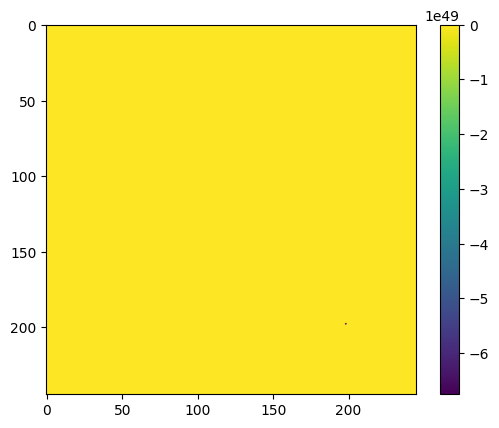

In [ ]:
plt.imshow(inv_mat)
plt.colorbar()

# 5)

# 6)

# 7)

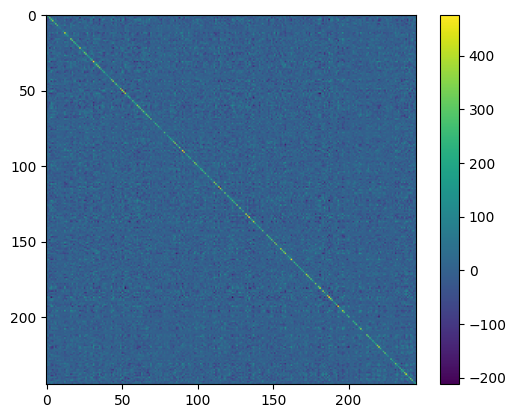

In [ ]:
pinv_mat = np.linalg.pinv(X_train.T@X_train)
plt.imshow(pinv_mat)
plt.colorbar()

From now on, we will use the built in functions from scikit learn to implement our models.
The cell below builds a linear regression model with biases and fits the coefficients to the training data.

In [ ]:
linreg_model = linear_model.LinearRegression(fit_intercept=True)
linreg_model.fit(X_train, Y_train)

LinearRegression()

The cell below evaluates the performance of the learned model on the test data.

In [ ]:
def degrees(Y):

  deg = np.degrees(np.arctan2(Y[:, 1], Y[:, 0]))
  deg = (deg + 360) % 360  #degrees between (0, 360(
  return deg

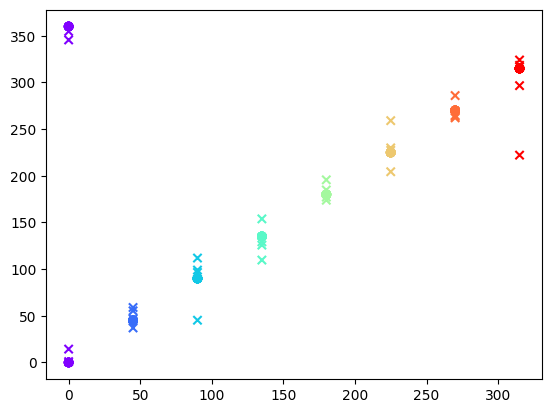

In [ ]:
colors_train = (np.arange(8)[:,None]*np.ones(nb_trials_train)).reshape(8*nb_trials_train)
colors_test =  (np.arange(8)[:,None]*np.ones(nb_trials_test)).reshape(8*nb_trials_test)

Y_train_predicted = linreg_model.predict(X_train)
Y_test_predicted = linreg_model.predict(X_test)


plt.scatter(degrees(Y_train), degrees(Y_train_predicted), c = colors_train, cmap = 'rainbow' )
plt.scatter(degrees(Y_test), degrees(Y_test_predicted), c = colors_test, cmap = 'rainbow', marker = 'x')


# 8)

# 9)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

def perform_kfold_validation(model, X, Y, k=8):

  kf = KFold(n_splits=k, shuffle=True) # Setting a random_state
  scores = []

  for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]


    model.fit(X_train, Y_train)
    score = model.score(X_val,Y_val)
    scores.append(score)

  return scores

score_linreg = np.zeros(100)

for i in range(100):
  scores = perform_kfold_validation(LinearRegression(fit_intercept=True), X_train, Y_train, k=5)
  score_linreg[i] = np.mean(scores)

In [ ]:
score_linreg.mean()

0.8226410301108159

# 10)

This can take a while

In [ ]:
# score_linreg = np.zeros(100)

from sklearn.linear_model import Ridge

alpha_list = np.logspace(-6, -1, 50)
score_ridge = np.zeros((100,50))

for alpha in alpha_list:
  for i in range(100):
    scores = perform_kfold_validation(Ridge(alpha=alpha, fit_intercept=True), X_train, Y_train, k=5)
    score_ridge[i,np.where(alpha_list == alpha)] = np.mean(scores)

# 11)

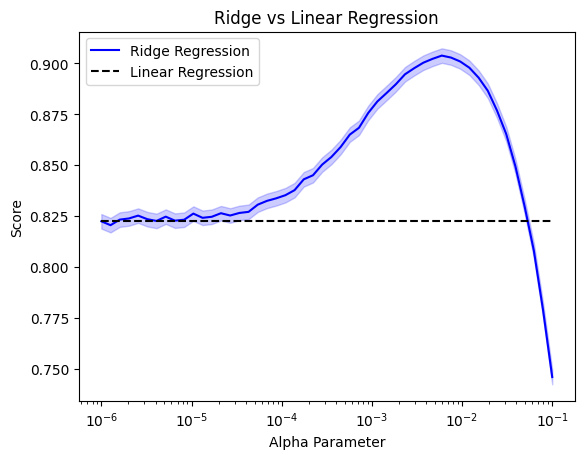

In [ ]:
# Compute means and standard errors
ridge_mean = score_ridge.mean(axis = 0)
ridge_sem = score_ridge.std() / np.sqrt(score_ridge.shape[0])  # ! this is the standard error not the STD!
linreg_mean = score_linreg.mean()

# Plot Ridge Regression with shaded error area
plt.plot(alpha_list, ridge_mean, label='Ridge Regression', color='blue')
plt.fill_between(alpha_list, ridge_mean - ridge_sem, ridge_mean + ridge_sem, color='blue', alpha=0.2)

# Plot Linear Regression as a horizontal line
plt.hlines(y=linreg_mean, xmin=alpha_list[0], xmax=alpha_list[-1], color='black', linestyle='--', label='Linear Regression')

# Set x-axis to logarithmic scale
plt.xscale('log')

# Add labels, legend, and show the plot
plt.xlabel("Alpha Parameter")
plt.ylabel("Score")
plt.legend()
plt.title("Ridge vs Linear Regression")
plt.show()

# 12)

In [ ]:
opt_alpha = alpha_list[np.argmax(ridge_mean)]
print('optimal alpha = ', opt_alpha)

optimal alpha =  0.005963623316594642


In [ ]:
X_train, X_test, Y_train, Y_test = get_XY_train_test()
ridge_model = Ridge(alpha=opt_alpha, fit_intercept=True)
ridge_model.fit(X_train, Y_train)

Ridge(alpha=0.005963623316594642)

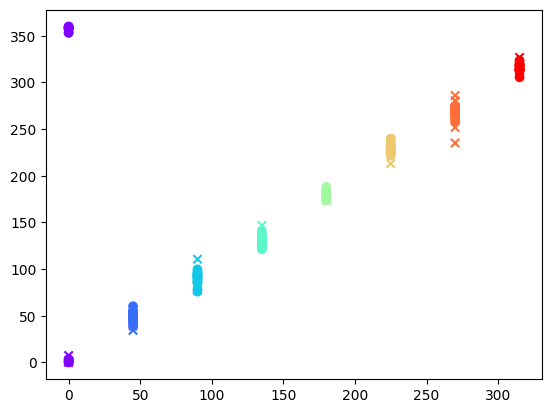

In [ ]:
colors_train = (np.arange(8)[:,None]*np.ones(nb_trials_train)).reshape(8*nb_trials_train)
colors_test =  (np.arange(8)[:,None]*np.ones(nb_trials_test)).reshape(8*nb_trials_test)

Y_train_predicted = ridge_model.predict(X_train)
Y_test_predicted = ridge_model.predict(X_test)

plt.scatter(degrees(Y_train), degrees(Y_train_predicted), c = colors_train, cmap = 'rainbow')
plt.scatter(degrees(Y_test), degrees(Y_test_predicted) , c = colors_test, cmap = 'rainbow', marker = 'x')

# 13)

# Implement the Lasso regression model with parameter 𝛼 = 10−4 and print the coefficients.

In [ ]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=1e-4, fit_intercept=True)
lasso_model.fit(X_train, Y_train)

#Coefficients from ridge and lasso models
ridge_coefficients = ridge_model.coef_
lasso_coefficients = lasso_model.coef_

print("Coefficients for the Lasso regression model (alpha = 10^(-4)) : ", lasso_model.coef_)

Coefficients for the Lasso regression model (alpha = 10^(-4)) :  [[ 0.00000000e+00  2.33103682e+00 -0.00000000e+00 -0.00000000e+00
   0.00000000e+00  3.51809627e+00  0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  3.74287479e+00  0.00000000e+00
   0.00000000e+00 -0.00000000e+00  2.67568763e+00 -0.00000000e+00
  -8.56009629e+00  0.00000000e+00 -0.00000000e+00 -5.86687448e-01
  -3.48184325e-01  0.00000000e+00 -0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.13255671e+00 -0.00000000e+00 -9.11982167e-01
   0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.01241163e+00
   1.36650313e+00  1.42979800e+01 -0.00000000e+00 -0.00000000e+00
   0.00000000e+00  4.12260710e+00  3.55200847e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  3.96579066e+00
  -0.00000000e+00  1.75871911e-02 -0.00000000e+00 -2.88058049e+00
  -0.000000

# 14)

This can take a while

In [ ]:
score_linreg = np.zeros(100)

for i in range(100):
  scores = perform_kfold_validation(LinearRegression(fit_intercept=True), X_train, Y_train, k=5)
  score_linreg[i] = np.mean(scores)

alpha_list = np.logspace(-5, -3, 50)
score_ridge = np.zeros((100,50))

for alpha in alpha_list:
  for i in range(100):
    ridge_model = Ridge(alpha=alpha, fit_intercept=True)
    scores = perform_kfold_validation(ridge_model, X_train, Y_train, k=5)
    score_ridge[i,np.where(alpha_list == alpha)] = np.mean(scores)



alpha_lasso_list = np.logspace(-5, -3, 50)
score_lasso = np.zeros((100, 50))

for alpha in alpha_lasso_list:
    for i in range(100):
        lasso_model = Lasso(alpha=alpha, fit_intercept=True, max_iter = 10000)
        scores = perform_kfold_validation(lasso_model, X_train, Y_train, k=5)
        score_lasso[i, np.where(alpha_lasso_list == alpha)] = np.mean(scores)



In [ ]:
opt_lasso_alpha = alpha_lasso_list[np.argmax(score_lasso.mean(axis=0))]

print('optimal alpha = ', opt_lasso_alpha)

optimal alpha =  0.00011513953993264469


# 15)

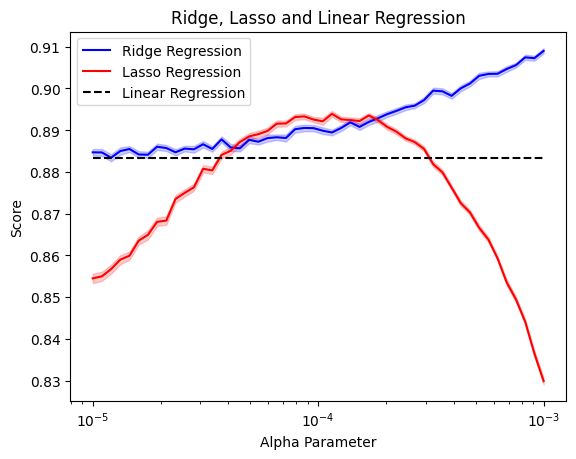

In [ ]:
# Compute means and standard errors
ridge_mean = score_ridge.mean(axis=0)
ridge_sem = score_ridge.std(axis =0)/ np.sqrt(score_ridge.shape[0]) # ! this is the standard error not the STD!
lasso_mean = score_lasso.mean(axis=0)
lasso_sem = score_lasso.std(axis=0) / np.sqrt(score_lasso.shape[0]) # ! this is the standard error not the STD!
linreg_mean = score_linreg.mean()

# Plot Ridge Regression with shaded error area
plt.plot(alpha_list, ridge_mean, label='Ridge Regression', color='blue')
plt.fill_between(alpha_list, ridge_mean - ridge_sem, ridge_mean + ridge_sem, color='blue', alpha=0.2)

# Plot Lasso Regression with shaded error area
plt.plot(alpha_lasso_list, lasso_mean, label='Lasso Regression', color='red')
plt.fill_between(alpha_lasso_list, lasso_mean - lasso_sem, lasso_mean + lasso_sem, color='red', alpha=0.2)


# Plot Linear Regression as a horizontal line
plt.hlines(y=linreg_mean, xmin=alpha_list[0], xmax=alpha_list[-1], color='black', linestyle='--', label='Linear Regression')

# Set x-axis to logarithmic scale
plt.xscale('log')

# Add labels, legend, and show the plot
plt.xlabel("Alpha Parameter")
plt.ylabel("Score")
plt.legend()
plt.title("Ridge, Lasso and Linear Regression")
plt.show()